# PYPROTOLINC Demo

This notebook demonstrates how the different concepts within `pyprotolinc` can be used explaining various
customization options.

In [1]:
# we will need a bunch of imports for the below
from enum import unique
from typing import Iterable, Union

import numpy as np
import numpy.typing as npt
import pandas as pd

from pyprotolinc.utils import TimeAxis
from pyprotolinc.models.state_models import show_state_models, AbstractStateModel, state_model_by_name, states_model
import pyprotolinc._actuarial as actuarial
from pyprotolinc.riskfactors.risk_factors import get_risk_factor_names, Gender, SmokerStatus
from pyprotolinc.assumptions.iohelpers import AssumptionsLoaderFromConfig
from pyprotolinc.assumptions.providers import AssumptionType
from pyprotolinc.product import show_products, register, AbstractProduct
from pyprotolinc.portfolio import Portfolio
from pyprotolinc.results import CfNames
from pyprotolinc.results import ProbabilityVolumeResults

# from pyprotolinc.assumptions.providers import AssumptionSetWrapper

## 1. State Models
As a first step a states model needs to be selected. We can choose between the built in states models or create a new one.

In [2]:
state_models = show_state_models()
state_models

{'AnnuityRunoffStates': <enum 'AnnuityRunoffStates'>,
 'MortalityStates': <enum 'MortalityStates'>,
 'MultiStateDisabilityStates': <enum 'MultiStateDisabilityStates'>}

We can look at the description of each of the built in models:

In [3]:
for state_model_name, state_model_class in state_models.items():
    print(state_model_class.describe())
    print()

AnnuityRunoffStates:  A state model consisting of two states:
        - DIS1 (=0) representing the annuity phase
        - DEATH (=1)
    

MortalityStates:  A state model with four states that can be used to model simple mortality term/perm products.
        - ACTIVE = 0
        - DEATH = 1
        - LAPSED = 2
        - MATURED = 3
    

MultiStateDisabilityStates:  A state model for a disabiility product with two disabled states. 
        - ACTIVE = 0
        - DIS1 = 1
        - DIS2 = 2
        - DEATH = 3
        - LAPSED = 4
    



We can now decide for one of the built-in models or create a custom model.

In [4]:
# decide for an existing one
# selected_state_model = state_model_by_name('MortalityStates')

# or create a new one by inheriting from AbstractStateModel
@states_model
@unique
class DeferredAnnuityStates(AbstractStateModel):
    """ A state model for a deferred annuities. 
        - ACTIVE = 0
        - ANNUITANT = 1
        - LAPSED = 2
        - DEAD = 3
    """
    ACTIVE = 0
    ANNUITANT = 1  # 6
    LAPSED = 2
    DEAD = 3

    @classmethod
    def to_std_outputs(cls: type["DeferredAnnuityStates"]) -> dict[ProbabilityVolumeResults,
                                                                   Union["AbstractStateModel",
                                                                         tuple["AbstractStateModel",
                                                                               "AbstractStateModel"]]]:
        return {
            ProbabilityVolumeResults.VOL_ACTIVE: cls.ACTIVE,
            ProbabilityVolumeResults.VOL_DIS1: cls.ANNUITANT,
            ProbabilityVolumeResults.VOL_DEATH: cls.DEAD,
            ProbabilityVolumeResults.VOL_LAPSED: cls.LAPSED,

            ProbabilityVolumeResults.MV_ACTIVE_DEATH: (cls.ACTIVE, cls.DEAD),
            ProbabilityVolumeResults.MV_ACTIVE_DIS1: (cls.ACTIVE, cls.ANNUITANT),
            ProbabilityVolumeResults.MV_ACT_LAPSED: (cls.ACTIVE, cls.LAPSED),

            ProbabilityVolumeResults.MV_DIS1_DEATH: (cls.ANNUITANT, cls.DEAD),
        }


# the new state model is now registered in pyprotolinc
show_state_models()

{'AnnuityRunoffStates': <enum 'AnnuityRunoffStates'>,
 'MortalityStates': <enum 'MortalityStates'>,
 'MultiStateDisabilityStates': <enum 'MultiStateDisabilityStates'>,
 'DeferredAnnuityStates': <enum 'DeferredAnnuityStates'>}

In [5]:
selected_state_model = state_model_by_name('DeferredAnnuityStates')

# print out the states
for state in selected_state_model:
    print(state)

DeferredAnnuityStates.ACTIVE
DeferredAnnuityStates.ANNUITANT
DeferredAnnuityStates.LAPSED
DeferredAnnuityStates.DEAD


### Mapping the States to the Standard Output Model
The next thing we need to specify is how the state should be mapped to the standatd output model
(if there is need for that at all)

In [6]:
# todo

## 2. Supplying Valuation Assumptions

We need to provide assumptions for the various state transitions in the model. In `pyprotolinc` this
is done by creating an object of type `AssumptionSet`. AssupmtionSets ar composed of `AssumptionProvides` and the the selection depends on `RiskFactors`.

### Risk Factors

Currently `pyprotolinc`supports five risk factors.

In [7]:
from pyprotolinc.riskfactors.risk_factors import _C_RISK_FACTORS
_C_RISK_FACTORS

{'Age': <CRiskFactors.Age: 0>,
 'Gender': <CRiskFactors.Gender: 1>,
 'CalendarYear': <CRiskFactors.CalendarYear: 2>,
 'SmokerStatus': <CRiskFactors.SmokerStatus: 3>,
 'YearsDisabledIfDisabledAtStart': <CRiskFactors.YearsDisabledIfDisabledAtStart: 4>}

In [8]:
# to better understand how the risk factors are encoded we can look at the values, e.g
[(g.name, g.value) for g in Gender]

[('M', 0), ('F', 1)]

In [9]:
[(g.name, g.value) for g in SmokerStatus]

[('S', 0), ('N', 1), ('A', 2), ('U', 3)]

### Building an Assumption Set

In [10]:
# the assumption set must have the dimension of the state models
states_dimension = len(selected_state_model)
acs = actuarial.AssumptionSet(states_dimension);

In [11]:
# to query the assumption set we need to provide values for each risk factor

# create a dummy realization of the risk factors
risk_factors = np.zeros(5, dtype=np.int32)
risk_factors[0] = 32              # age
risk_factors[1] = Gender.F        # gender
risk_factors[2] = 2023            # CalendarYear
risk_factors[3] = SmokerStatus.N  # SmokerStatus
risk_factors[4] = -1              # YearsDisabledIfDisabledAtStart

risk_factors

array([  32,    1, 2023,    1,   -1])

In [12]:
# at this stage we can already query
acs.get_single_rateset(risk_factors).reshape((states_dimension, states_dimension))

array([[0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.]])

All possible state transitions have a (independent) transition probabilities of zero.

### Providers

Assumption Providers are multidimensional lookup tables that specify the transition probabilities for a single state transition depending on the risk factors.

In [13]:
# to illustrate that we specify a provider programmatically that depends on Gender and Age

vals2D = np.array([
       [0.1, 0.2, 0.3, 0.4],  # specifies Gender M and ages 0, 1, 2, 3
       [1.1, 1.2, 1.3, 1.4]   # specifies Gender M and ages 0, 1, 2, 3
], dtype=np.float64)

offsets = np.zeros(2, dtype=np.int32)
provider_test = actuarial.StandardRateProvider([actuarial.CRiskFactors.Gender, actuarial.CRiskFactors.Age], vals2D, offsets)

In [14]:
# we can query the provider for gender F and age 2
provider_test.get_rate((Gender.F, 2))

1.3

In [15]:
# we create a dummy provider programmatically for all ages
vals2d_long = (np.arange(120 * 2)).reshape((2, 120)) / 1000.0
vals2d_long

array([[0.   , 0.001, 0.002, 0.003, 0.004, 0.005, 0.006, 0.007, 0.008,
        0.009, 0.01 , 0.011, 0.012, 0.013, 0.014, 0.015, 0.016, 0.017,
        0.018, 0.019, 0.02 , 0.021, 0.022, 0.023, 0.024, 0.025, 0.026,
        0.027, 0.028, 0.029, 0.03 , 0.031, 0.032, 0.033, 0.034, 0.035,
        0.036, 0.037, 0.038, 0.039, 0.04 , 0.041, 0.042, 0.043, 0.044,
        0.045, 0.046, 0.047, 0.048, 0.049, 0.05 , 0.051, 0.052, 0.053,
        0.054, 0.055, 0.056, 0.057, 0.058, 0.059, 0.06 , 0.061, 0.062,
        0.063, 0.064, 0.065, 0.066, 0.067, 0.068, 0.069, 0.07 , 0.071,
        0.072, 0.073, 0.074, 0.075, 0.076, 0.077, 0.078, 0.079, 0.08 ,
        0.081, 0.082, 0.083, 0.084, 0.085, 0.086, 0.087, 0.088, 0.089,
        0.09 , 0.091, 0.092, 0.093, 0.094, 0.095, 0.096, 0.097, 0.098,
        0.099, 0.1  , 0.101, 0.102, 0.103, 0.104, 0.105, 0.106, 0.107,
        0.108, 0.109, 0.11 , 0.111, 0.112, 0.113, 0.114, 0.115, 0.116,
        0.117, 0.118, 0.119],
       [0.12 , 0.121, 0.122, 0.123, 0.124, 0.12

In [16]:
provider = actuarial.StandardRateProvider([actuarial.CRiskFactors.Gender, actuarial.CRiskFactors.Age], vals2d_long, offsets)
provider.get_rate([Gender.F, 9])

0.129

In [17]:
# now we can add this provider to the assumption set for the state-transition 1 -> 0
acs.add_provider_std(1, 0, provider)

Now that we have added a provider we can query the assumption set again:

In [18]:
# query for the rates associated with the risk factors specified above
acs.get_single_rateset(risk_factors).reshape((states_dimension, states_dimension))

array([[0.   , 0.   , 0.   , 0.   ],
       [0.152, 0.   , 0.   , 0.   ],
       [0.   , 0.   , 0.   , 0.   ],
       [0.   , 0.   , 0.   , 0.   ]])

The number (!=0) we see is in the second row (corresponding with STATE#1) and gives us the
probability to transition to STATE#0 (first column).

### Building AssumptionSets from Files

Instead manually bootstrapping the required object there is a more convenient way for simpler cases to **create 
assumptions sets from configruration files and spreadsheets**.

In [19]:
assumption_config_loader = AssumptionsLoaderFromConfig(r"..\di_assumptions.yml", states_dimension)
assumption_config_loader.assumptions_spec

{'be': [[0,
   3,
   ['FileTable', 'base_assumptions_annuity.xlsx', 'MORTALITY (0->3)']],
  [0, 2, ['FileTable', 'base_assumptions_annuity.xlsx', 'LAPSE (0->2)']],
  [1, 3, ['FileTable', 'base_assumptions_annuity.xlsx', 'DIS_DEATH (1->3)']]],
 'res': [[0,
   3,
   ['FileTable', 'base_assumptions_annuity.xlsx', 'MORTALITY (0->3)']],
  [0, 2, ['FileTable', 'base_assumptions_annuity.xlsx', 'LAPSE (0->2)']],
  [1, 3, ['FileTable', 'base_assumptions_annuity.xlsx', 'DIS_DEATH (1->3)']]]}

In [20]:
assumption_set_wrapper = assumption_config_loader.load()

In [21]:
# some possible checks
# assumption_set_wrapper.be_transitions
# assumption_set_wrapper.be_transitions[0][2].get_values()
# assumption_set_wrapper.build_rates_provides_matrix(AssumptionType.BE)

In [22]:
# now we construct an assumption set from the wrapper and query again:
acs2 = assumption_set_wrapper.build_assumption_set(AssumptionType.BE)
acs2.get_single_rateset(risk_factors).reshape((states_dimension, states_dimension))

array([[0.      , 0.      , 0.049   , 0.000725],
       [0.      , 0.      , 0.      , 0.06    ],
       [0.      , 0.      , 0.      , 0.      ],
       [0.      , 0.      , 0.      , 0.      ]])

In [23]:
# risk_factors

## 3. Record Data

The next input we need is the portfolio data, i.e. file containing seriatim records. The most convenient way is to import a portfolio from an Excel file using a ``pyprotolinc.portfolio.PortfolioLoader`` object.

In [24]:
import pyprotolinc.portfolio as ptf

portfolio_path = "../portfolio_small3.xlsx"
ptf_loader = ptf.PortfolioLoader(portfolio_path)

Portfolio files have to look like this (where the order of the columns does not matter):

In [25]:
df_portfolio = pd.read_excel(portfolio_path)
df_portfolio

,DATE_PORTFOLIO,ID,DATE_OF_BIRTH,DATE_START_OF_COVER,SUM_INSURED,CURRENT_STATUS,SEX,PRODUCT,PRODUCT_PARAMETERS,SMOKERSTATUS,RESERVING_RATE,DATE_OF_DISABLEMENT
0,2021-12-31,1,1976-04-23,2022-01-01,1000,ACTIVE,m,DeferredAnnuity,NaN,U,0,2022-01-31
1,2021-12-31,2,1969-03-03,2022-01-01,100,ACTIVE,f,DeferredAnnuity,NaN,U,0,2023-05-31
2,2021-12-31,3,1970-09-13,2022-01-01,5000,ANNUITANT,f,DeferredAnnuity,NaN,U,0,2005-10-06


The columns have the obvious meanings:

* DATE_PORTFOLIO the date at which the snapshot is valid, must be equal for all records.
* ID a unique indentifier
* DATE_OF_BIRTH
* DATE_START_OF_COVER
* SUM_INSURED sum insured (or yearly annuity amount)
* CURRENT_STATUS corresponds with the state in the state model the record is in at DATE_PORTFOLIO
* SEX gender (m/f)
* PRODUCT is a string that references a product
* PRODUCT_PARAMETERS additional product parameters
* SMOKERSTATUS
* RESERVING_RATE the interest rate that should be used for the reserve calculations
* DATE_OF_DISABLEMENT
    
When importing using the `loader` certain validations will be performed on the fly and to be able to validate the the status a corresponding state model class must be passed in to load the portfolio:

In [26]:
# load the portfolio object
portfolio = ptf_loader.load(selected_state_model)
portfolio

<Portfolio with 3 records and state model <enum 'DeferredAnnuityStates'>

Moreover, to save some time a cacheing of the portfolios is implemented when instatiating with a second path::
 
    ptf.PortfolioLoader(portfolio_path, cache_path)

Then pickled versions of the portfolios read will be stored under the path and searching for portfolios to load will be done there first.

### 4. Products

The final ingredient needed is the definition of the life insurance product. As already seen the product is specified
on the policy level in the portfolio file as a string.

First let's have a look at what is there.

In [27]:
# list the registered products
show_products()

[('ANNUITYINPAYMENT',
  pyprotolinc.product.Product_AnnuityInPayment,
  ' Simple product that pays out the sum_insured / 12 each month. '),
 ('ANNUITYINPAYMENTYEARLYATBIRTHMONTH',
  pyprotolinc.product.Product_AnnuityInPaymentYearlyAtBirthMonth,
  ' Simple product that pays out the sum_insured each year at the\n        month of birth. '),
 ('TWOSTATEDISABILITY',
  pyprotolinc.product.Product_TwoStateDisability,
  ' Income protection product with two disabled states. '),
 ('TERM',
  pyprotolinc.product.Product_MortalityTerm,
  ' Simple product that pays out on death.'),
 ('MORTALITYTERM',
  pyprotolinc.product.Product_MortalityTerm,
  ' Simple product that pays out on death.')]

The starting point for an own product is a class like this.

In [28]:
# @register - we will register later with a direct call
class Product_DeferredAnnuity(AbstractProduct):
    """ Simple product that pays out on death."""

    STATES_MODEL = DeferredAnnuityStates
    PRODUCT_NAMES = ("DeferredAnnuity")

    def __init__(self, portfolio: Portfolio) -> None:
        super().__init__(portfolio)

    def get_bom_payments(self, time_axis: TimeAxis) -> dict[AbstractStateModel,
                                                            list[tuple[CfNames, npt.NDArray[np.float64]]]]:
        """ Return the 'conditional payments', i.e. those payments that are due if an
            insured is in the corresponding state at the given time. """
        return {}
    
    def get_state_transition_payments(self, time_axis: TimeAxis) -> dict[tuple[AbstractStateModel,
                                                                               AbstractStateModel],
                                                                         list[tuple[CfNames,
                                                                                    npt.NDArray[np.float64]]]]:
        return {}

    def contractual_state_transitions(self, time_axis: TimeAxis) -> Iterable[tuple[AbstractStateModel,
                                                                                   AbstractStateModel,
                                                                                   npt.NDArray[np.int32]]]:
        # for the mortality term product there is only the transition
        # ACTIVE -> ANNUITANT
        return []

We construct the *Contractual State Transition* first.

In [29]:
# to test the implementation we need a TimeAxis:
time_axis = TimeAxis(portfolio.portfolio_date, 12 * 5)
time_axis.years, time_axis.months

(array([2021, 2022, 2022, 2022, 2022, 2022, 2022, 2022, 2022, 2022, 2022,
        2022, 2022, 2023, 2023, 2023, 2023, 2023, 2023, 2023, 2023, 2023,
        2023, 2023, 2023, 2024, 2024, 2024, 2024, 2024, 2024, 2024, 2024,
        2024, 2024, 2024, 2024, 2025, 2025, 2025, 2025, 2025, 2025, 2025,
        2025, 2025, 2025, 2025, 2025, 2026, 2026, 2026, 2026, 2026, 2026,
        2026, 2026, 2026, 2026, 2026, 2026], dtype=int32),
 array([12,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12,  1,  2,  3,  4,
         5,  6,  7,  8,  9, 10, 11, 12,  1,  2,  3,  4,  5,  6,  7,  8,  9,
        10, 11, 12,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12,  1,  2,
         3,  4,  5,  6,  7,  8,  9, 10, 11, 12], dtype=int32))

In [30]:
# we need to determine when the transition to the ANNUITANT state will be,
# we can start here:
portfolio.months_till_disablement

array([   1,   17, -195], dtype=int64)

In [31]:
# now we need to build an indicator matrix
relative_months = np.arange(len(time_axis)).reshape((len(time_axis), 1))
annuity_start_indicator = (relative_months == portfolio.months_till_disablement).astype(np.int32).transpose()
annuity_start_indicator

array([[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]])

We can build the transitions from this.

For the payments we need a premium in active state and an annuity payment while in ANNUITANT state.

In [32]:
class Product_DeferredAnnuity(AbstractProduct):
    """ Simple product that pays out on death."""

    STATES_MODEL = DeferredAnnuityStates
    PRODUCT_NAMES = ("DeferredAnnuity", )

    def __init__(self, portfolio: Portfolio) -> None:
        super().__init__(portfolio)
        
        self.portfolio = portfolio
 
    def get_bom_payments(self, time_axis: TimeAxis) -> dict[AbstractStateModel,
                                                            list[tuple[CfNames, npt.NDArray[np.float64]]]]:
        """ Return the 'conditional payments', i.e. those payments that are due if an
            insured is in the corresponding state at the given time. """
        premium = 0.2 * self.sum_insured_per_month
        return {
            self.STATES_MODEL.ACTIVE: [
                (CfNames.PREMIUM, np.dot(premium, np.ones((1, len(time_axis)))))
            ],
            self.STATES_MODEL.ANNUITANT: [
                (CfNames.ANNUITY_PAYMENT1, -np.dot(self.sum_insured_per_month,
                                                   np.ones((1, len(time_axis)))))
            ]
        }
    
    def get_state_transition_payments(self, time_axis: TimeAxis) -> dict[tuple[AbstractStateModel,
                                                                               AbstractStateModel],
                                                                         list[tuple[CfNames,
                                                                                    npt.NDArray[np.float64]]]]:
        # no transitions needed
        return {}

    def contractual_state_transitions(self, time_axis: TimeAxis) -> Iterable[tuple[AbstractStateModel,
                                                                                   AbstractStateModel,
                                                                                   npt.NDArray[np.int32]]]:
        # for the mortality term product there is only the transition
        # ACTIVE -> ANNUITANT
       
        relative_months = np.arange(len(time_axis)).reshape((len(time_axis), 1))
        annuity_start_indicator = (relative_months == self.portfolio.months_till_disablement).astype(np.int32).transpose()

        return [
            (self.STATES_MODEL.ACTIVE, self.STATES_MODEL.ANNUITANT, annuity_start_indicator)
        ]

# here we register the product
register(Product_DeferredAnnuity)

__main__.Product_DeferredAnnuity

In [33]:
# assert 1 == 0

### 5. Main Configuration Object

To start a run we have to combine all the relevant information in a single configuration object.

In [34]:
from importlib import reload

import pyprotolinc
reload(pyprotolinc)

<module 'pyprotolinc' from 'C:\\Programming\\python\\PyProtolinc\\src\\pyprotolinc\\__init__.py'>

Most of the values have sensible defaults but one must be provided: the name of the state model.

In [35]:
run_cfg = pyprotolinc.RunConfig(working_directory = ".", state_model_name=selected_state_model.__name__)

The object's ``__init__`` method has the following signature:
    
    def __init__(self,
                 state_model_name: str,
                 working_directory: Path = ".",
                 model_name: str = "GenericMultiState",
                 years_to_simulate: int = 120,
                 steps_per_month: int = 1,
                 portfolio_path: Optional[str] = None,
                 assumptions_path: Optional[str] = None,
                 outfile: str = "ncf_out_generic.csv",
                 portfolio_cache: Optional[str] = None,
                 profile_out_dir: Optional[str] = None,
                 portfolio_chunk_size: int = 20000,
                 use_multicore: bool = False,
                 kernel_engine: str = "PY",
                 max_age: int = 120
                 ) -> None:

It is also possible and often more convenient to load a configuration object from a file.

In [36]:
run_cfg2 = pyprotolinc.get_config_from_file("../config.yml")

### 6. Starting a Run

Runs can be triggered by two methods in the module ``pyprotolinc.main``: either ``project_cashflows`` or ``project_cashflows_cli``.

If using the latter all data must be delivered via the config file path or object. The former allows
to inject programmatic objects.

In [37]:
from pyprotolinc.main import project_cashflows

In [38]:
run_result = project_cashflows(run_cfg, df_portfolio, assumption_set_wrapper, export_to_file=False)

INFO - 2023-03-26 20:55:51,476 - pyprotolinc.main - Multistate run with config: {'working_directory': '.', 'model_name': 'GenericMultiState', 'years_to_simulate': 119, 'portfolio_path': None, 'assumptions_path': None, 'steps_per_month': 1, 'state_model_name': 'DeferredAnnuityStates', 'timestep_duration': 0.08333333333333333, 'outfile': 'ncf_out_generic.csv', 'portfolio_cache': None, 'profile_out_dir': None, 'portfolio_chunk_size': 20000, 'use_multicore': False, 'kernel_engine': 'PY', 'max_age': 119}
DEBUG - 2023-03-26 20:55:51,476 - pyprotolinc.portfolio - Initializing portfolio from dataframe
DEBUG - 2023-03-26 20:55:51,491 - pyprotolinc.portfolio - Splitting portfolio for product DEFERREDANNUITY.
DEBUG - 2023-03-26 20:55:51,491 - pyprotolinc.portfolio - Initializing portfolio from dataframe
DEBUG - 2023-03-26 20:55:51,499 - pyprotolinc.portfolio - Initializing portfolio from dataframe
DEBUG - 2023-03-26 20:55:51,509 - pyprotolinc.portfolio - Initializing portfolio from dataframe
INFO

In [40]:
df_result = pd.DataFrame(run_result)
# df_result.to_excel("result_deferred_annuity_out.xlsx")
df_result

,YEAR,QUARTER,MONTH,PREMIUM,ANNUITY_PAYMENT1,ANNUITY_PAYMENT2,DEATH_PAYMENT,DI_LUMPSUM_PAYMENT,RESERVE_BOM(ACTIVE),RESERVE_BOM(ANNUITANT),...,MV_ACTIVE_DIS1,MV_ACT_DIS2,MV_ACT_LAPSED,MV_ACT_MATURED,MV_DIS1_DEATH,MV_DIS1_DIS2,MV_DIS1_ACT,MV_DIS2_DEATH,MV_DIS2_DIS1,MV_DIS2_ACT
0,2021,4,12,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.000000,...,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0
1,2022,1,1,18.333333,-416.666667,0.0,0.0,0.0,21357.502667,83268.443291,...,0.995514,0.0,0.008333,0.0,0.005000,0.0,0.0,0.0,0.0,0.0
2,2022,1,2,1.659194,-497.542833,0.0,0.0,0.0,1517.012483,102710.600141,...,0.000000,0.0,0.004148,0.0,0.009123,0.0,0.0,0.0,0.0,0.0
3,2022,1,3,1.651756,-495.124252,0.0,0.0,0.0,1518.671678,102213.057308,...,0.000000,0.0,0.004129,0.0,0.009081,0.0,0.0,0.0,0.0,0.0
4,2022,2,4,1.644350,-492.717476,0.0,0.0,0.0,1520.323433,101717.933056,...,0.000000,0.0,0.004111,0.0,0.009039,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1424,2140,3,8,0.000000,-0.558322,0.0,0.0,0.0,0.000000,2.765640,...,0.000000,0.0,0.000000,0.0,0.000019,0.0,0.0,0.0,0.0,0.0
1425,2140,3,9,0.000000,-0.555713,0.0,0.0,0.0,0.000000,2.207318,...,0.000000,0.0,0.000000,0.0,0.000019,0.0,0.0,0.0,0.0,0.0
1426,2140,4,10,0.000000,-0.553116,0.0,0.0,0.0,0.000000,1.651606,...,0.000000,0.0,0.000000,0.0,0.000019,0.0,0.0,0.0,0.0,0.0
1427,2140,4,11,0.000000,-0.550531,0.0,0.0,0.0,0.000000,1.098490,...,0.000000,0.0,0.000000,0.0,0.000019,0.0,0.0,0.0,0.0,0.0


### 7. Result Presentation

DEBUG - 2023-03-26 21:04:12,892 - matplotlib.pyplot - Loaded backend module://matplotlib_inline.backend_inline version unknown.


<AxesSubplot:>

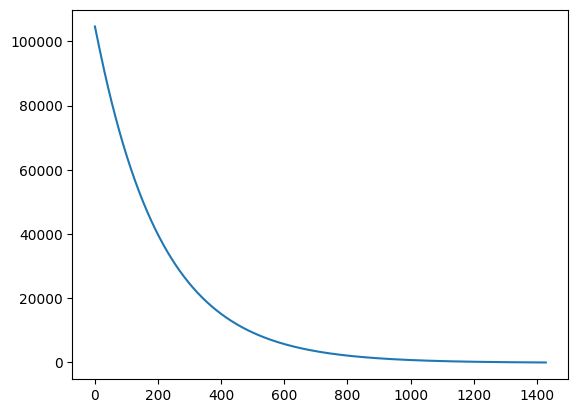

In [46]:
%matplotlib inline
#df_result[["RESERVE_BOM(ACTIVE)", "RESERVE_BOM(ANNUITANT)"]].plot()
(df_result["RESERVE_BOM(ACTIVE)"] + df_result["RESERVE_BOM(ANNUITANT)"])[1:].plot();